In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
%load_ext line_profiler

from coeditor.common import *
import os
from coeditor.model import RetrievalEditorModel, AttentionMode, DecodingArgs, EditCostModel
from coeditor.service import EditPredictionService, ChangeDetector
from coeditor.c3problem import C3GeneratorCache, C3Problem, C3ProblemTokenizer

os.chdir(proj_root())

In [ ]:
# target_dir = proj_root() / "../SPOT-copy/"
target_dir = proj_root()
model_name = "coeditor-xl-c3-dropout-v1.6-resumed"
model_path = get_model_dir(True) / model_name
model = RetrievalEditorModel.load(model_path)
model.to("cuda:2")


In [ ]:
testset: list[C3Problem] = pickle_load(
    get_dataset_dir("xl")
    / "transformed"
    / "C3ProblemGenerator(VERSION=2.9)-C3ProblemChangeDropout(VERSION=1.3)"
)["test"]
len(testset)


39477

In [ ]:
subset = list[C3Problem]()
for ex in tqdm(testset):
    ex = ex.restrict_span_changes()
    c = ex.span.get_change()
    if len(c.before) <= 6000 and len(c.after) <= 6000:
        subset.append(ex)


100%|██████████| 39477/39477 [00:58<00:00, 669.33it/s] 


In [ ]:
cm = EditCostModel()
subset = subset[0:-1:10]
all_costs = pmap(
    cm.get_edit_gain,
    [ex.span.original.tolist() for ex in subset],
    [ex.span.delta for ex in subset],
)
scalar_stats(all_costs)


pmap: get_edit_gain: 100%|██████████| 3682/3682 [00:32<00:00, 114.87it/s]


{'mean': 101.811515480717, 'median': 43.0, 'min': 0, 'max': 2399}

(array([728., 547., 426., 271., 252., 170., 154., 121.,  93.,  87.,  76.,
         51.,  51.,  63.,  37.,  36.,  47.,  39.,  32.,  31.,  22.,  25.,
         26.,  11.,  20.,  20.,  17.,  10.,  11.,   9.,  10.,   8.,   5.,
          8.,   8.,   5.,   7.,  10.,   9.,   6.]),
 array([  0. ,  12.5,  25. ,  37.5,  50. ,  62.5,  75. ,  87.5, 100. ,
        112.5, 125. , 137.5, 150. , 162.5, 175. , 187.5, 200. , 212.5,
        225. , 237.5, 250. , 262.5, 275. , 287.5, 300. , 312.5, 325. ,
        337.5, 350. , 362.5, 375. , 387.5, 400. , 412.5, 425. , 437.5,
        450. , 462.5, 475. , 487.5, 500. ]),
 <BarContainer object of 40 artists>)

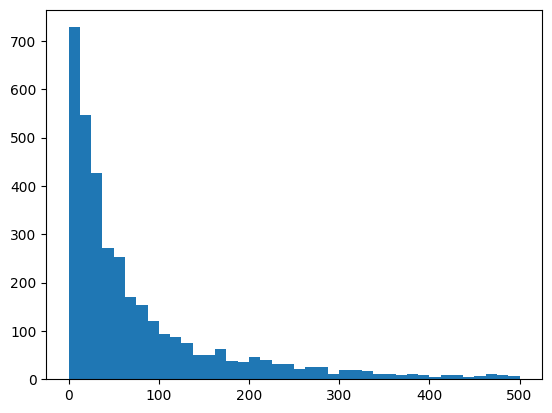

In [ ]:
# plot a histogram of the costs
import matplotlib.pyplot as plt

plt.hist(all_costs, bins=40, range=(0, 500))


In [ ]:
subset = [ex for i, ex in enumerate(subset) if 50 <= all_costs[i] <= 500]
len(subset)


1587

cm = EditCostModel()
%timeit -n 1 -r 3 all_costs = [cm.get_edit_gain(ex.span.original.tolist(), ex.span.delta) for ex in tqdm(testset[:50])]

In [ ]:
tokenizer = C3ProblemTokenizer(
    max_query_tks=1024,
    max_ref_tks=1024,
    max_output_tks=512,
    max_ref_tks_sum=1024 * 12,
)
dec_args = DecodingArgs(do_sample=False, num_beams=1, length_penalty=0.0)

# %lprun -f -u 0.001 RetrievalEditorModel.multi_round_edit_gain
multi_stats = [
    model.multi_round_edit_gain(ex, tokenizer, dec_args, print_steps=False)
    for ex in tqdm(subset, smoothing=0.0)
]


100%|██████████| 1587/1587 [1:35:15<00:00,  3.60s/it]


In [ ]:
keys = ["label_edit_gain", "first_edit_gain", "total_edit_gain", "rounds"]
stats = {k: scalar_stats([getattr(s, k) for s in multi_stats]) for k in keys}   
pretty_print_dict(stats)

print(f"For all edits (n={len(multi_stats)}):")
label_sum = sum(s.label_edit_gain for s in multi_stats)
single_sum = sum(s.first_edit_gain for s in multi_stats)
multi_sum = sum(s.total_edit_gain for s in multi_stats)
print(f"Single-round Gain ratio: {single_sum / label_sum:.2%}")
print(f"Multi-round Gain ratio: {multi_sum / label_sum:.2%}")

big_stats = [s for s in multi_stats if 100 <= s.label_edit_gain]
print(f"For big edits (n={len(big_stats)}):")
label_sum = sum(s.label_edit_gain for s in big_stats)
single_sum = sum(s.first_edit_gain for s in big_stats)
multi_sum = sum(s.total_edit_gain for s in big_stats)
print(f"Single-round Gain ratio: {single_sum / label_sum:.2%}")
print(f"Multi-round Gain ratio: {multi_sum / label_sum:.2%}")

label_edit_gain:
   mean: 149.16
   median: 113
   min: 50
   max: 498
first_edit_gain:
   mean: 45.066
   median: 16
   min: 0
   max: 467
total_edit_gain:
   mean: 63.48
   median: 51
   min: -155
   max: 459
rounds:
   mean: 3.1638
   median: 3
   min: 1
   max: 8
For all edits (n=1587):
Single-round Gain ratio: 30.21%
Multi-round Gain ratio: 42.56%
For big edits (n=890):
Single-round Gain ratio: 26.75%
Multi-round Gain ratio: 40.00%


In [ ]:
# find the first index where the edit gain is less than 0
ex_id = next(i for i, s in enumerate(multi_stats) if s.total_edit_gain < 0)
ex = subset[ex_id]
ex.print()

--------------------------------------------------------------------------------
summary:
path: ghost/cli
project: EntySec?Ghost
commit: CommitInfo(hash='4e25989af187bf9fcb2f3c4d208155a442aa4632', parents=('d480c76b551b6309850059e75bceb2ec24feb252',), msg='Update __init__.py')
--------------------------------------------------------------------------------
main change:
<add>     """ Ghost Framework command-line interface.
 <add> 
 <add>     :return None: None
 <add>     """
 <add> 
    console = Console()
    console.shell()

--------------------------------------------------------------------------------
edit_line_ids:
(0, 1, 2, 3)


In [ ]:
from coeditor.encoding import tokens_to_change, show_change, decode_tokens
from dataclasses import replace
from coeditor.tk_array import TkArray

problem = ex
tokenizer = service.c3_tkn
dec_args = service.dec_args
dec_args.num_beams = 1

model.multi_round_edit_gain(problem, service.c3_tkn, dec_args, print_steps=True)

--------------------------------------------------------------------------------
gold_change:
Modified: 
  +     """ Ghost Framework command-line interface.
  +
  +     :return None: None
  +     """
  +
        console = Console()
        console.shell()
 
Remaining changes:
TkDelta(
  0: ('<add>     """ Ghost Framework command-line interface.\r', '<add> \r', '<add>     :return None: None\r')
  1: ('<add> \r',)
)
insert lines: (0,3), cost=75
insert lines: (4,5), cost=4
total cost: 79
--------------------------------------------------------------------------------
round:
1
--------------------------------------------------------------------------------
path: ghost/cli
n_references: 1
total_reference_tks: 12
project: EntySec?Ghost
commit: CommitInfo(hash='4e25989af187bf9fcb2f3c4d208155a442aa4632', parents=('d480c76b551b6309850059e75bceb2ec24feb252',), msg='Update __init__.py')
========Ground Truth========
 <0>:<add>     """ Ghost Framework command-line interface.
     <add> 
     <add> 

MultiRoundEditStats(label_edit_gain=79, first_edit_gain=0, total_edit_gain=-2, rounds=4)